In [1]:
!pip install shortuuid

In [33]:
import sys
import os
import math
import base64
import boto3
import sagemaker
import matplotlib.pyplot as plt
import numpy as np
import collections
from collections import defaultdict
from PIL import Image
import sklearn
from sklearn.metrics import ConfusionMatrixDisplay
from matplotlib.ticker import NullFormatter
from sklearn import manifold, datasets
from time import time

To avoid altering the conda environment of this notebook and introducing versioning conflicts, we do not pip -r the bioims cli requirements.txt file, although this would would be preferable than using pip directly here. 

In [3]:
s3c = boto3.client('s3')

In [4]:
%pwd

'/root/bioimage-search/datasets/bbbc-021/notebooks'

In [5]:
bioimsArtifactBucket='bioimagesearchbasestack-bioimagesearchdatabucketa-16h77xh6oyxmm'

In [6]:
# assumes cwd=/root/bioimage-search/datasets/bbbc-021/notebooks
sys.path.insert(0, "../../../cli/bioims/src")
import bioims as bi

In [7]:
sagemaker_session = sagemaker.Session()
bucket = sagemaker_session.default_bucket()
role = sagemaker.get_execution_role()

In [8]:
print(role)

arn:aws:iam::580829821648:role/service-role/AmazonSageMaker-ExecutionRole-20200608T200997


## Prerequisites

### Permissions
This notebook requires adding the "BioimageSearch" managed policy to the above SageMaker execution role. Do this by using the IAM console to add the policy to the above role. The policy arn will be something like: arn:aws:iam::580829821648:policy/BioimageSearchResourcePermissionsStack-biomageSearchManagedPolicy9CB9C1D7-SXEV4WNUCZ7V

### TrainID
This notebook does a baseline, or sanity-check, on the training of the bbbc-021 dataset with a particular model, the context for which is specified by a BioimageSearch 'trainId', an output of the training process. If the evaluation of the results looks reasonable, then the comprehensive 'mechanism of action' (MOA) training series can be run, which creates a separate model for each chemical treatment with known MOA. This collection of models, in turn, can be evaluated to determine the likelihood of whether a treatment of unknown MOA would be properly classified. If so, then the model is likely to be useful for assigning MOA to treatments with unknown mechanisms of action, and more broadly for representing a molecule in 'MOA space'.

In [9]:
trainId = 'r6KEudzQCuUtDwCzziiMZT'

### Steps
* Get the Embedding for the TrainId
* Get the dimensions for the Embedding
* Get the list of compatible plates
* For each plate:
 * Get the origin row of each image to get its metadata
 * Get the embeddings for the specified TrainId
* Combine the metadata and embeddings into a tablular object
* Visualize separability
 * Compute the average embedding for each well
 * Label each well by known MOA (for cases where MOA is known)
 * Use a projection method (e.g., t-sne) to view the separability of results
* Create 'baseline' confusion matrix (not valid due to circular model inclusion, but just for sanity check)
 * For each treatment with known MOA:
   * Compute average across corresponding wells
   * Find the MOA of its nearest neighbor
 * Plot matrix

In [10]:
trainClient = bi.client('training-configuration')

In [11]:
trainInfo = trainClient.getTraining(trainId)

In [12]:
trainInfo

{'filterBucket': '',
 'embeddingName': 'bbbc021',
 'sagemakerJobName': 'bioims-r6KEudzQCuUtDwCzziiMZT-o9C8cSPpy6uvvB49mVF3Dq',
 'messageId': '61eb03ea-56b2-4645-8f75-c1da1758ccc5',
 'filterKey': '',
 'trainId': 'r6KEudzQCuUtDwCzziiMZT'}

In [13]:
embeddingInfo = trainClient.getEmbeddingInfo(trainInfo['embeddingName'])

In [14]:
embeddingInfo

{'roiDepth': 1,
 'trainingHyperparameters': {'backend': 'gloo',
  'batch_size': 1,
  'seed': 1,
  'epochs': 15},
 'roiHeight': 128,
 'trainId': 'origin',
 'inputHeight': 1024,
 'inputWidth': 1280,
 'comments': '',
 'inputChannels': 3,
 'imageMethodArn': 'arn:aws:batch:us-east-1:580829821648:job-definition/imagepreprocessingjobde-af308e24979dc7d:15',
 'embeddingVectorLength': 32,
 'trainingInstanceType': 'ml.p3.2xlarge',
 'plateMethodArn': 'arn:aws:batch:us-east-1:580829821648:job-definition/platepreprocessingjobde-586209612f00161:18',
 'inputDepth': 1,
 'modelTrainingScriptBucket': 'bioimage-search-input',
 'wellMethodArn': 'wellMethodArn-placeholder',
 'imagePostMethodArn': 'imagePostMethodArn-placeholder',
 'embeddingName': 'bbbc021',
 'modelTrainingScriptKey': 'bbbc021-train-script.py',
 'roiWidth': 128}

In [15]:
imageClient = bi.client('image-management')

In [16]:
plates = imageClient.listCompatiblePlates(embeddingInfo['inputWidth'], embeddingInfo['inputHeight'], embeddingInfo['inputDepth'], embeddingInfo['inputChannels'])

In [17]:
plates

[{'plateId': 'dVUYu3LHsVdX2QjDvjkWBZ'},
 {'plateId': 'tUyR81nttbs4oTerCmeY1W'},
 {'plateId': 'acGUmAXyN2KX5t2rsyXDML'},
 {'plateId': '3E7FGfD4P1cD3KYpTrrWTH'},
 {'plateId': 'mbCcinNjMAAytVbZstPTPm'},
 {'plateId': '5ZH9Fu2CYdh26nEbS3oAYk'},
 {'plateId': 'iWnggLioEtZy2A5j1rnnEA'},
 {'plateId': '5np41A3ZuJqab1FLuQ7o29'},
 {'plateId': 'anigW7bu1gcYTyx8ZaSN9v'},
 {'plateId': 'gXc7VwBnbjUsk9wDdemqJK'},
 {'plateId': 'so3zBsJWXGFBYzAHrTpZSM'},
 {'plateId': 'u92kqVRfvHvWcFrqPxgGn7'},
 {'plateId': '7trLchpg8wHF9APLk4s7V6'},
 {'plateId': 'bmRW9E3q3Q7b6ra22aLvng'},
 {'plateId': 'wAUJq2ZLHnod3DubxQExnF'},
 {'plateId': 'qM42Ff4KhNmVtHUVRuhTMA'},
 {'plateId': 'a3eEV8qyGrgfXmotLPHiaL'},
 {'plateId': 'wU1q4A7NNcFQp2XETDLUkH'},
 {'plateId': 'bkoWwh2MzFXYWYQNWtyZTm'},
 {'plateId': '41uoJSLaYcGhYyoiQeLbgs'},
 {'plateId': 'srMypE2cV8eUHvEMsxsv4L'},
 {'plateId': 'rkktcPFgaFjkdeCPNnputx'},
 {'plateId': 'rGwJ8zvBo7evsQMW3ZyicR'},
 {'plateId': 'cP2PAvpnERZnk4PjcMZUDj'},
 {'plateId': 'iSFeJJnF7KVBsM2vQ8gf6Y'},


In [18]:
imagePlateExample = imageClient.getImagesByPlateId(plates[0]['plateId'])

In [19]:
imagePlateExample[0]

{'Item': {'trainCategory': 'moa',
  'imageId': '31BGyiGKAvfHKCCoRNvYwc',
  'plateId': 'dVUYu3LHsVdX2QjDvjkWBZ',
  'trainId': 'origin',
  'depth': '1',
  'plateSourceId': 'Week9_39282',
  'bucket': 'bioimagesearchbbbc021stack-bbbc021bucket544c3e64-10ecnwo51127',
  'experiment': 'BBBC021_v1',
  'channelKeys': [{'name': 'dapi',
    'keysuffix': 'Week9_39282/Week9_090907_C11_s4_w135A3E11A-6F0C-4141-80A1-0CB26C00C42B.tif'},
   {'name': 'tubulin',
    'keysuffix': 'Week9_39282/Week9_090907_C11_s4_w2DEB25F7A-011E-438E-87C2-D5EEA8F4FD55.tif'},
   {'name': 'actin',
    'keysuffix': 'Week9_39282/Week9_090907_C11_s4_w4B8176253-2C7D-492A-9370-F9623E3115BA.tif'}],
  'wellId': 'fc9XAcR7mYMbFtTJD7o2C1',
  'imageSourceId': 'Week9_090907_C11_s4_w135A3E11A-6F0C-4141-80A1-0CB26C00C42B',
  'messageId': 'b2b876d1-f042-4aae-8270-f393f8425e34',
  'searchReady': 'VALIDATED',
  'height': '1024',
  'width': '1280',
  'wellSourceId': 'C11',
  'channels': '3',
  'trainLabel': 'Microtubule stabilizers',
  'key': '

In [20]:
embeddingPlateExample = imageClient.getImagesByPlateIdAndTrainId(plates[0]['plateId'], trainId)

In [21]:
embeddingPlateExample[0]

{'Item': {'imageId': '1quQgPAWunz5jTEjKiNAfZ',
  'embedding': "b'i6qJPbpKHL5IZSK+akeqPRVh570Wlvm869mrvXp6Pj5qKMy918wAvnCsQr6zHe+91nTsvalCALx3twG+Et21PRMvhb1Qzkw8mda2PYVZtD2RXyu7ggIWPs4AnT2keSE9oQ8ePqkEvL0bN4K97uzDPQ1NuD22JbO8TTCPvHkVCr0='",
  'roiEmbeddingKey': 'artifact/train/r6KEudzQCuUtDwCzziiMZT/plate/dVUYu3LHsVdX2QjDvjkWBZ/1quQgPAWunz5jTEjKiNAfZ-roi-embedding.npy',
  'trainId': 'r6KEudzQCuUtDwCzziiMZT'}}

In [63]:
e1 = "b'i6qJPbpKHL5IZSK+akeqPRVh570Wlvm869mrvXp6Pj5qKMy918wAvnCsQr6zHe+91nTsvalCALx3twG+Et21PRMvhb1Qzkw8mda2PYVZtD2RXyu7ggIWPs4AnT2keSE9oQ8ePqkEvL0bN4K97uzDPQ1NuD22JbO8TTCPvHkVCr0='"

In [64]:
e2 = e1.split("\'")

In [65]:
e3=e2[1].encode()

In [66]:
e4 = base64.decodebytes(e3)
e5 = np.frombuffer(e4, dtype=np.float32)

In [67]:
e5

array([ 0.06721982, -0.15262881, -0.15858948,  0.08314402, -0.11297814,
       -0.03046707, -0.08391174,  0.18601409, -0.09968646, -0.1257814 ,
       -0.19011092, -0.11675587, -0.11545722, -0.00782839, -0.12667643,
        0.08880056, -0.06503119,  0.01250036,  0.0892765 ,  0.08806137,
       -0.00261495,  0.14649394,  0.07666169,  0.03942265,  0.1543565 ,
       -0.09180576, -0.06358167,  0.09566675,  0.08999071, -0.02186857,
       -0.01747909, -0.03371188], dtype=float32)

In [68]:
plateMap={}

In [69]:
for plateEntry in plates:
    plateId=plateEntry['plateId']
    print("Adding plateId {}".format(plateId))
    images=imageClient.getImagesByPlateId(plateId)
    embeddings=imageClient.getImagesByPlateIdAndTrainId(plateId, trainId)
    imageMap={}
    for imageItem in images:
        image=imageItem['Item']
        imageId=image['imageId']
        imageMap[imageId]=image
    print("  found {} image entries".format(len(imageMap)))
    embeddingMap={}
    for embeddingItem in embeddings:
        if 'Item' in embeddingItem:
            embedding=embeddingItem['Item']
            imageId=embedding['imageId']
            e1=embedding['embedding']
            e2=e1.split("\'")
            e3=e2[1].encode()
            e4=base64.decodebytes(e3)
            e5=np.frombuffer(e4, dtype=np.float32)
            embedding['np']=e5
            embeddingMap[imageId]=embedding
    print("  found {} embedding entries".format(len(embeddingMap)))
    plateInfo = {
        "images" : imageMap,
        "embeddings" : embeddingMap
    }
    plateMap[plateId]=plateInfo

Adding plateId dVUYu3LHsVdX2QjDvjkWBZ
  found 240 image entries
  found 238 embedding entries
Adding plateId tUyR81nttbs4oTerCmeY1W
  found 240 image entries
  found 240 embedding entries
Adding plateId acGUmAXyN2KX5t2rsyXDML
  found 240 image entries
  found 240 embedding entries
Adding plateId 3E7FGfD4P1cD3KYpTrrWTH
  found 240 image entries
  found 226 embedding entries
Adding plateId mbCcinNjMAAytVbZstPTPm
  found 240 image entries
  found 240 embedding entries
Adding plateId 5ZH9Fu2CYdh26nEbS3oAYk
  found 240 image entries
  found 239 embedding entries
Adding plateId iWnggLioEtZy2A5j1rnnEA
  found 240 image entries
  found 236 embedding entries
Adding plateId 5np41A3ZuJqab1FLuQ7o29
  found 240 image entries
  found 232 embedding entries
Adding plateId anigW7bu1gcYTyx8ZaSN9v
  found 240 image entries
  found 232 embedding entries
Adding plateId gXc7VwBnbjUsk9wDdemqJK
  found 240 image entries
  found 240 embedding entries
Adding plateId so3zBsJWXGFBYzAHrTpZSM
  found 240 image entr

# Review Plate Images

Here I'd like to select a plate and visualize all composite images.

In [70]:
artifactClient=bi.client('artifact')

In [71]:
artifactClient.getArtifacts('1xDNMw2ZFhpSGDTppgyeMU', 'origin')

[{'contextId': '1xDNMw2ZFhpSGDTppgyeMU#origin',
  'annotation': [],
  'description': '',
  'artifact': 's3key#artifact/plate/dVUYu3LHsVdX2QjDvjkWBZ/default/image/1xDNMw2ZFhpSGDTppgyeMU/medium-2d.png',
  'createTimestamp': '1609119906187'},
 {'contextId': '1xDNMw2ZFhpSGDTppgyeMU#origin',
  'annotation': [],
  'description': '',
  'artifact': 's3key#artifact/plate/dVUYu3LHsVdX2QjDvjkWBZ/default/image/1xDNMw2ZFhpSGDTppgyeMU/thumbnail-2d.png',
  'createTimestamp': '1609119905306'}]

In [72]:
plateId = 'tUyR81nttbs4oTerCmeY1W'

In [73]:
def showImage(im):
    #plt.figure(figsize=(20,15))
    plt.figure(figsize=(4,15))
    plt.subplot(1,1,1)
    plt.xticks([])
    plt.yticks([])
    print("shape=", im.size)
    print("format=", im.format)
    ip=plt.imshow(im)
    #plt.xlabel(0)
    plt.show()

In [74]:
def displayImages(images, columns, fx, fy):
    plt.figure(figsize=(fx,fy))
    l =len(images)
    spx=columns
    spy=math.ceil(l/spx)
    i=0
    for imkey in images:
        fo = s3c.get_object(Bucket=bioimsArtifactBucket, Key=imkey)
        fs = fo['Body']
        im = Image.open(fs)
        plt.subplot(spy,spx,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(im)
        plt.xlabel(i)
        i+=1

In [75]:
def displayThumbnailsForPlate(plateId):
    plateDataMap = plateMap[plateId]
    imageMap = plateDataMap['images']
    imageIds = imageMap.keys()
    keyList = []
    for imageId in imageIds:
        artifactList = artifactClient.getArtifacts(imageId, 'origin')
        for artifact in artifactList:
            s3key = artifact['artifact']
        if s3key.endswith('thumbnail-2d.png'):
            components = s3key.split('#')
            keyList.append(components[1])
    displayImages(keyList, 10, 20, 40)

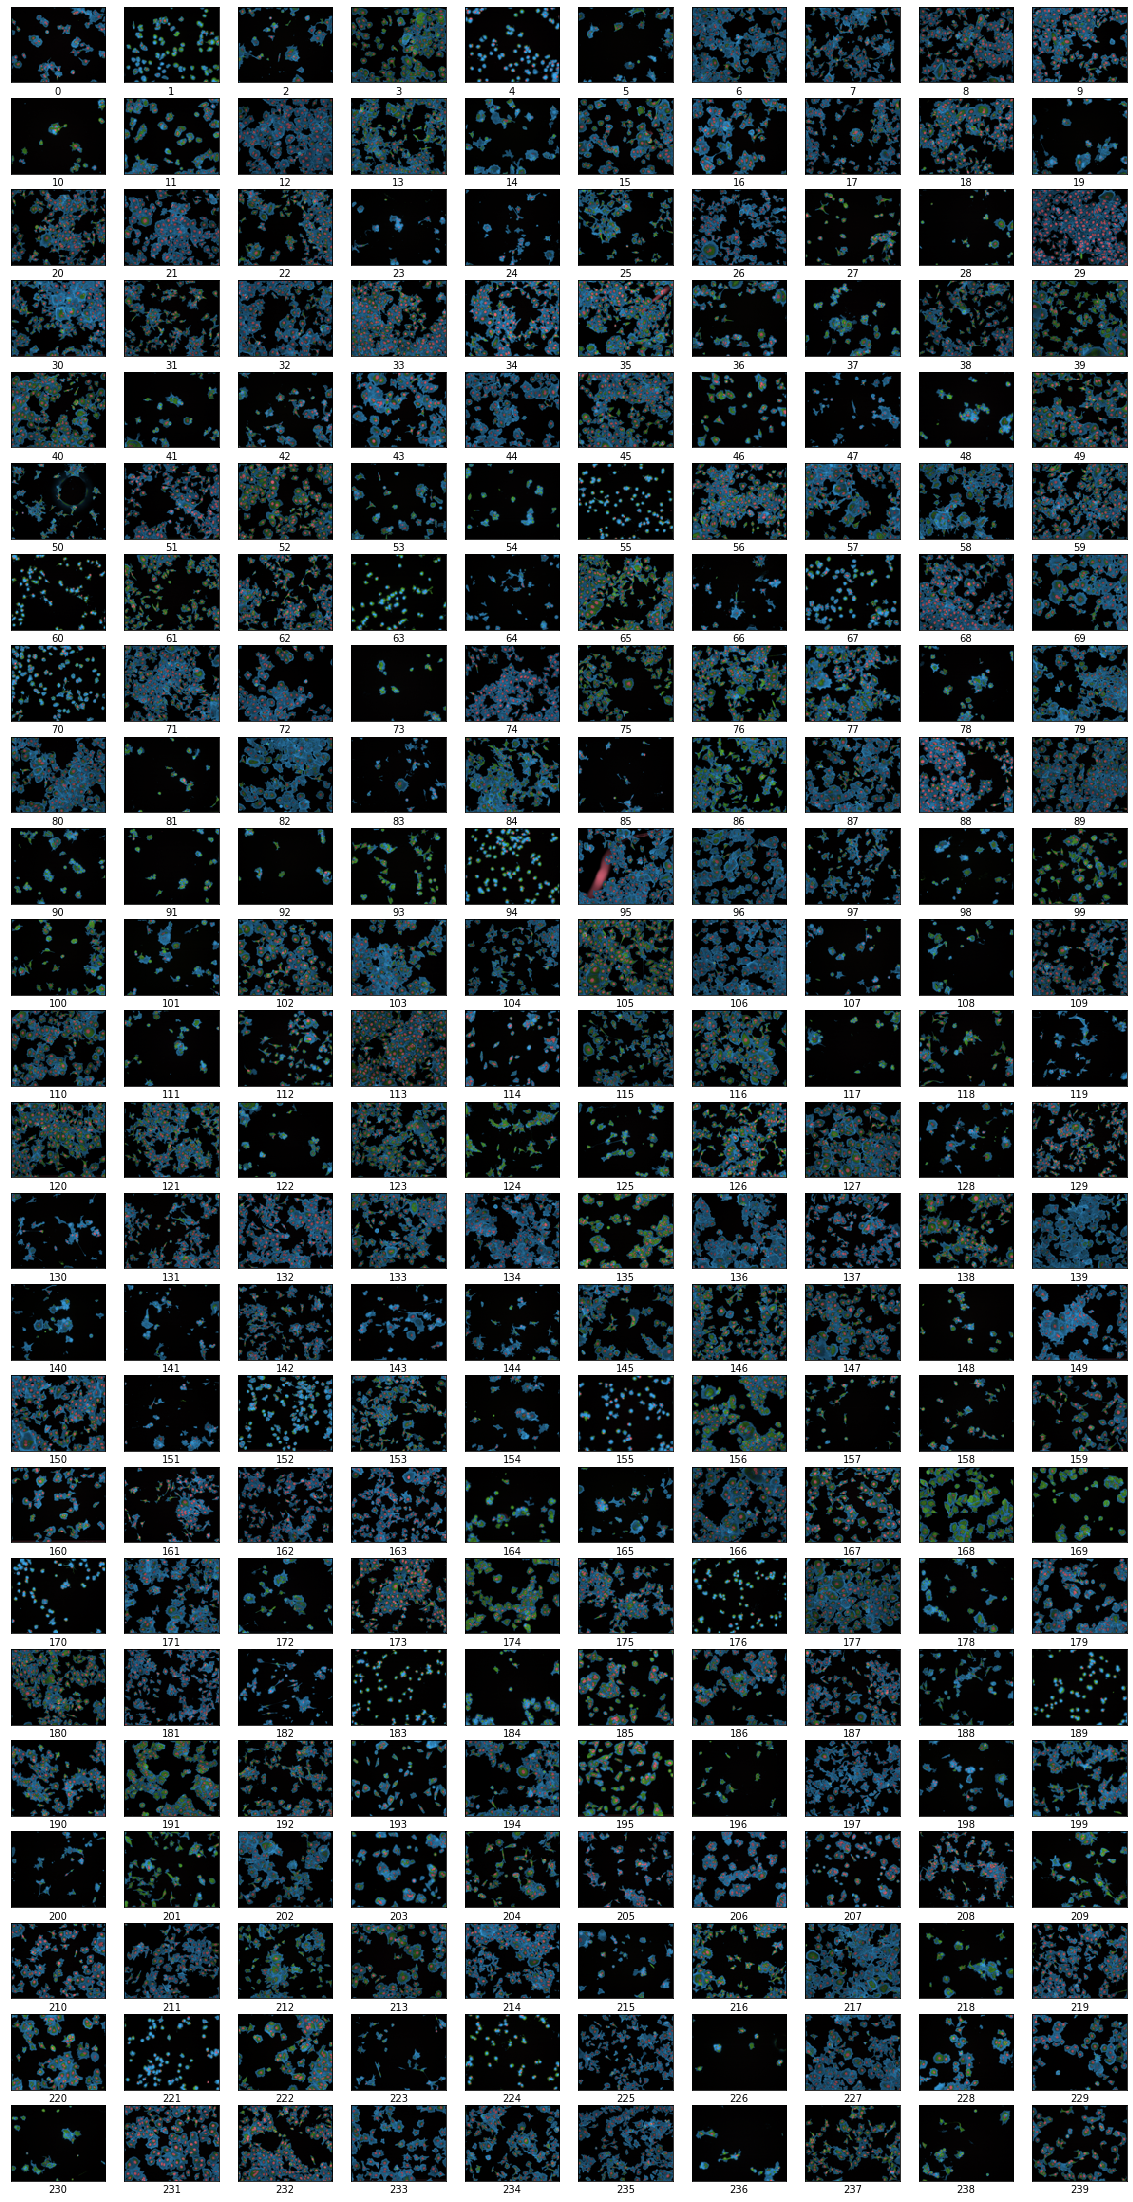

In [76]:
displayThumbnailsForPlate(plateId)

Next, we create a mapping from MOA->well-embedding, where we will naively take the average of the embeddings for each well (there are several images per well). An alternative would be taking the median.

In [91]:
wellMap = {}

In [92]:
imageCount=0
for plateId in plateMap:
    print("plate {}".format(plateId))
    plateInfo = plateMap[plateId]
    imageMap = plateInfo['images']
    embeddingMap = plateInfo['embeddings']
    for imageId in imageMap:
        imageInfo = imageMap[imageId]
        if imageId in embeddingMap:
            embeddingInfo = embeddingMap[imageId]
            if 'trainLabel' in imageInfo and 'np' in embeddingInfo:
                wellId = imageInfo['wellId']
                if wellId not in wellMap:
                    imageArr = []
                    wellMap[wellId]=imageArr
                imageArr = wellMap[wellId]
                imageEntry = {}
                imageEntry['label']=imageInfo['trainLabel']
                imageEntry['np']=embeddingInfo['np']
                imageArr.append(imageEntry)
                imageCount+=1
print("Found {} wells".format(len(wellMap)))
print("Found {} images with MOA labels and embeddings".format(imageCount))

plate dVUYu3LHsVdX2QjDvjkWBZ
plate tUyR81nttbs4oTerCmeY1W
plate acGUmAXyN2KX5t2rsyXDML
plate 3E7FGfD4P1cD3KYpTrrWTH
plate mbCcinNjMAAytVbZstPTPm
plate 5ZH9Fu2CYdh26nEbS3oAYk
plate iWnggLioEtZy2A5j1rnnEA
plate 5np41A3ZuJqab1FLuQ7o29
plate anigW7bu1gcYTyx8ZaSN9v
plate gXc7VwBnbjUsk9wDdemqJK
plate so3zBsJWXGFBYzAHrTpZSM
plate u92kqVRfvHvWcFrqPxgGn7
plate 7trLchpg8wHF9APLk4s7V6
plate bmRW9E3q3Q7b6ra22aLvng
plate wAUJq2ZLHnod3DubxQExnF
plate qM42Ff4KhNmVtHUVRuhTMA
plate a3eEV8qyGrgfXmotLPHiaL
plate wU1q4A7NNcFQp2XETDLUkH
plate bkoWwh2MzFXYWYQNWtyZTm
plate 41uoJSLaYcGhYyoiQeLbgs
plate srMypE2cV8eUHvEMsxsv4L
plate rkktcPFgaFjkdeCPNnputx
plate rGwJ8zvBo7evsQMW3ZyicR
plate cP2PAvpnERZnk4PjcMZUDj
plate iSFeJJnF7KVBsM2vQ8gf6Y
plate iZXb4GHd82mCYueSLDU2Fj
plate hTzLRgf8iBu64UyWo3TABJ
plate 48Eg3emAXHqik5LSori6j8
plate gXc3iRxAi4rs5AdwQpYeiZ
plate rTYWQb3gCFGhXbQEvLNSCn
plate 36xGRy8wVuxRDZHLj5ht4U
plate jdZqYfQqNTRbv78dEeSkCz
plate vHi2JRppovJW3H33D1XAif
plate ugqm3HW8XGMr1W8F4ThpGm
plate hdXSxK41

In [95]:
moaMap={}

In [99]:
for wellId in wellMap:
    imageArr = wellMap[wellId]
    label = imageArr[0]['label']
    if label not in moaMap:
        wellArr = []
        moaMap[label]=wellArr
    wellArr = moaMap[label]
    embeddingArr = []
    for imageEntry in imageArr:
        embeddingArr.append(imageEntry['np'])
    npa = np.asarray(embeddingArr)
    npm = np.mean(npa, axis=0)
    wellArr.append(npm)

In [100]:
for label in moaMap:
    wellArr = moaMap[label]
    print("label {} has {} entries".format(label, len(wellArr)))

label DMSO has 330 entries
label DNA replication has 96 entries
label Cholesterol-lowering has 48 entries
label Microtubule stabilizers has 402 entries
label Actin disruptors has 72 entries
label Protein degradation has 94 entries
label Epithelial has 64 entries
label Microtubule destabilizers has 96 entries
label Aurora kinase inhibitors has 72 entries
label DNA damage has 96 entries
label Protein synthesis has 72 entries
label Kinase inhibitors has 48 entries
label Eg5 inhibitors has 45 entries
